In [1]:
import numpy as np, pandas as pd
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (summarize,
                         poly,
                         ModelSpec as MS)
from statsmodels.stats.anova import anova_lm
from pygam import (s as s_gam,
                   l as l_gam,
                   f as f_gam,
                   LinearGAM,
                   LogisticGAM)
from ISLP.models import sklearn_sm
from ISLP.transforms import (BSpline,
                             NaturalSpline)
from ISLP.models import bs, ns
from ISLP.pygam import (approx_lam,
                        degrees_of_freedom,
                        plot as plot_gam,
                        anova as anova_gam)
from sklearn.model_selection import cross_validate, KFold, train_test_split
from functools import partial
from ISLP.models import \
     (Stepwise,
      sklearn_selected,
      sklearn_selection_path)
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# Question 6

In [2]:
Wage = load_data('Wage')

In [3]:
Wage.head()

year  age            maritl      race        education              region  \
0  2006   18  1. Never Married  1. White     1. < HS Grad  2. Middle Atlantic   
1  2004   24  1. Never Married  1. White  4. College Grad  2. Middle Atlantic   
2  2003   45        2. Married  1. White  3. Some College  2. Middle Atlantic   
3  2003   43        2. Married  3. Asian  4. College Grad  2. Middle Atlantic   
4  2005   50       4. Divorced  1. White       2. HS Grad  2. Middle Atlantic   

         jobclass          health health_ins   logwage        wage  
0   1. Industrial       1. <=Good      2. No  4.318063   75.043154  
1  2. Information  2. >=Very Good      2. No  4.255273   70.476020  
2   1. Industrial       1. <=Good     1. Yes  4.875061  130.982177  
3  2. Information  2. >=Very Good     1. Yes  5.041393  154.685293  
4  2. Information       1. <=Good     1. Yes  4.318063   75.043154

### (a) Polynomial Regression

In [4]:
y = Wage['wage']
age = Wage['age']

In [5]:
# init cv
cv = KFold(n_splits=5, shuffle=True, random_state=0)

In [6]:
# understanding np.power.outer
a = np.asarray([1, 2, 3, 4])
np.power.outer(a, np.arange(5+1)) # np.arange starts with 0 (intercept in this case) so + 1

array([[   1,    1,    1,    1,    1,    1],
       [   1,    2,    4,    8,   16,   32],
       [   1,    3,    9,   27,   81,  243],
       [   1,    4,   16,   64,  256, 1024]])

In [7]:
degrees = range(1, 6)
cv_error = np.zeros(len(degrees))
age_poly_features = np.asarray(age)

# loop through models and get cv errors
for i, degree in enumerate(degrees):
    X = np.power.outer(age_poly_features, np.arange(degree+1))
    CV = cross_validate(sklearn_sm(sm.OLS), 
                        X, 
                        y,
                        cv=cv)
    cv_error[i] = np.mean(CV['test_score'])
cv_error

array([1675.97797787, 1600.6843786 , 1597.00855538, 1596.20945876,
       1598.21530779])

#### Cross Validation
Best error at degree=4.

In [8]:
models = [MS([poly('age', degree=d)]) 
          for d in degrees]
Xs = [model.fit_transform(Wage) for model in models]
anova_lm(*[sm.OLS(y, X_).fit()
           for X_ in Xs])

df_resid           ssr  df_diff        ss_diff           F        Pr(>F)
0    2998.0  5.022216e+06      0.0            NaN         NaN           NaN
1    2997.0  4.793430e+06      1.0  228786.010128  143.593107  2.363850e-32
2    2996.0  4.777674e+06      1.0   15755.693664    9.888756  1.679202e-03
3    2995.0  4.771604e+06      1.0    6070.152124    3.809813  5.104620e-02
4    2994.0  4.770322e+06      1.0    1282.563017    0.804976  3.696820e-01

#### ANOVA
Anova agrees, with degree=4, with p-value = 5.105%

#### Plot

In [9]:
def plot_wage_fit(age_df, 
                  basis,
                  title):

    X = basis.transform(Wage)
    Xnew = basis.transform(age_df)
    M = sm.OLS(y, X).fit()
    preds = M.get_prediction(Xnew)
    bands = preds.conf_int(alpha=0.05)
    fig, ax = subplots(figsize=(8,8))
    ax.scatter(age,
               y,
               facecolor='gray',
               alpha=0.5)
    for val, ls in zip([preds.predicted_mean,
                      bands[:,0],
                      bands[:,1]],
                     ['b','r--','r--']):
        ax.plot(age_df.values, val, ls, linewidth=3)
    ax.set_title(title, fontsize=20)
    ax.set_xlabel('Age', fontsize=20)
    ax.set_ylabel('Wage', fontsize=20);
    return ax

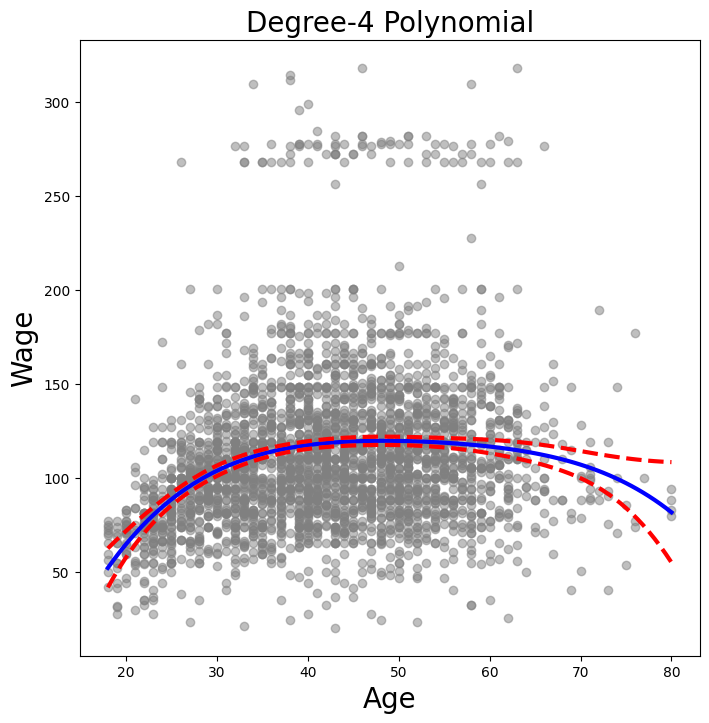

In [10]:
poly_age = MS([poly('age', degree=4)]).fit(Wage)
age_grid = np.linspace(age.min(),
                       age.max(),
                       100)
age_df = pd.DataFrame({'age': age_grid})

plot_wage_fit(age_df, 
              poly_age,
              'Degree-4 Polynomial');

### (b) Step Function

In [11]:
age = Wage['age']

In [12]:
cuts = range(1, 20)
cv_error = np.zeros(len(cuts))

# loop through models and get cv errors
for i, cut in enumerate(cuts):
    cut_age = pd.qcut(age, cut + 1)
    X = pd.get_dummies(cut_age)
    CV = cross_validate(sklearn_sm(sm.OLS), 
                        X, 
                        y,
                        cv=cv)
    cv_error[i] = np.mean(CV['test_score'])
cv_error

array([1703.98624771, 1660.21747041, 1643.54893817, 1641.65415209,
       1636.90408532, 1627.35473711, 1624.53060805, 1625.31470466,
       1619.42520284, 1622.99428956, 1622.98944769, 1616.50042257,
       1613.99483953, 1617.08432164, 1617.62667623, 1620.03577132,
       1618.02476215, 1617.60926168, 1618.28838019])

In [13]:
min_idx = np.argmin(cv_error)
cv_error[min_idx], min_idx

(1613.9948395341758, 12)

#### Step Function CV
Best CV error occurs with 12 cuts.

In [14]:
# Final model
cuts = 12
cut_age, bins = pd.qcut(age, cuts + 1, retbins=True)
X = pd.get_dummies(cut_age)
mod = sm.OLS(y, X).fit()

#### Plot

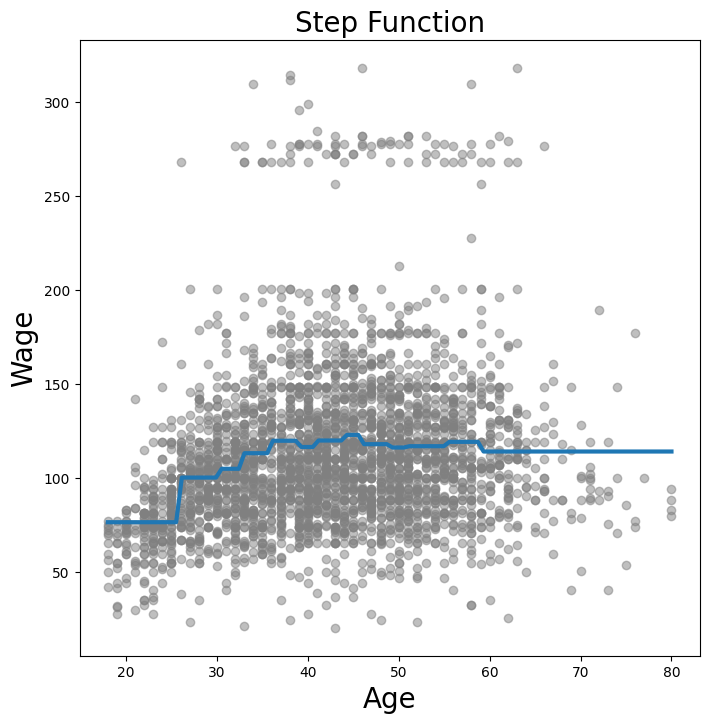

In [15]:
age_df = pd.DataFrame({'age': age_grid})

cut_age_grid = pd.cut(age_grid, bins=bins, include_lowest=True)
Xnew = pd.get_dummies(cut_age_grid)
preds = mod.get_prediction(Xnew)
bands = preds.conf_int(alpha=0.05)
fig, ax = subplots(figsize=(8,8))
ax.scatter(age,
           y,
           facecolor='gray',
           alpha=0.5) # just age against wage
ax.plot(age_df.values, preds.predicted_mean, linewidth=3)
ax.set_title('Step Function', fontsize=20)
ax.set_xlabel('Age', fontsize=20)
ax.set_ylabel('Wage', fontsize=20);

# Question 7

### Models
1. maritl, jobclass and age 
2. jobclass + age
3. maritl + age

In [16]:
Wage['maritl'] = Wage['maritl'].astype('category')
Wage['jobclass'] = Wage['jobclass'].astype('category')

In [17]:
# s for smoothing spline
# l for linear
# f for categorical
gam_full = LinearGAM(s_gam(0) + f_gam(1, lam=0) + f_gam(2, lam=0)) # age + maritl + jobclass
Xgam = np.column_stack([age,
                        Wage['jobclass'].cat.codes,
                        Wage['maritl'].cat.codes])
gam_full = gam_full.fit(Xgam, y)

gam_job = LinearGAM(s_gam(0) + f_gam(1, lam=0)) 
gam_job = gam_job.fit(Xgam, y)

gam_maritl = LinearGAM(s_gam(0) + f_gam(2, lam=0)) 
gam_maritl = gam_maritl.fit(Xgam, y)

In [18]:
anova_gam(gam_job, gam_maritl, gam_full) # shows full model is best

deviance           df  deviance_diff   df_diff           F  \
0  4.583674e+06  2983.792999            NaN       NaN         NaN   
1  4.631290e+06  2980.795863  -47615.678433  2.997136  -10.615260   
2  4.459636e+06  2979.796157  171654.007748  0.999706  114.727839   

         pvalue  
0           NaN  
1  1.000000e+00  
2  8.824273e-10

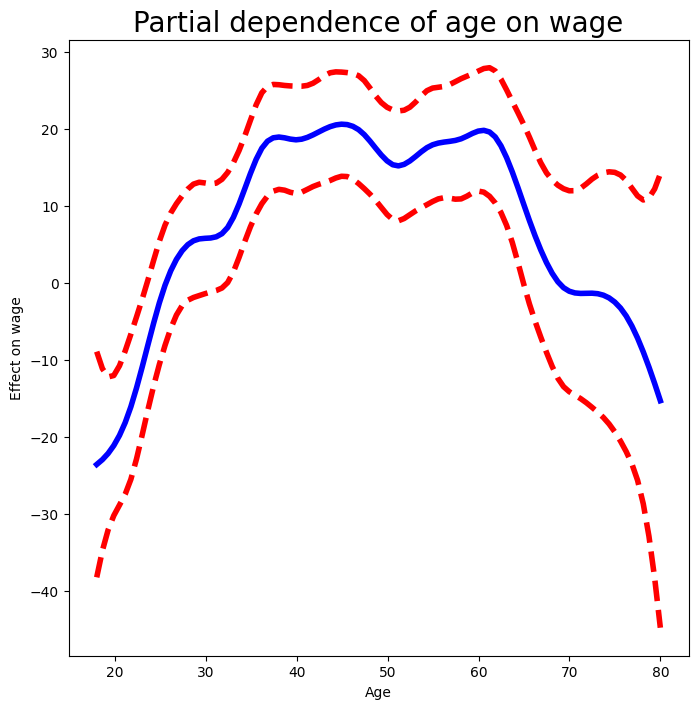

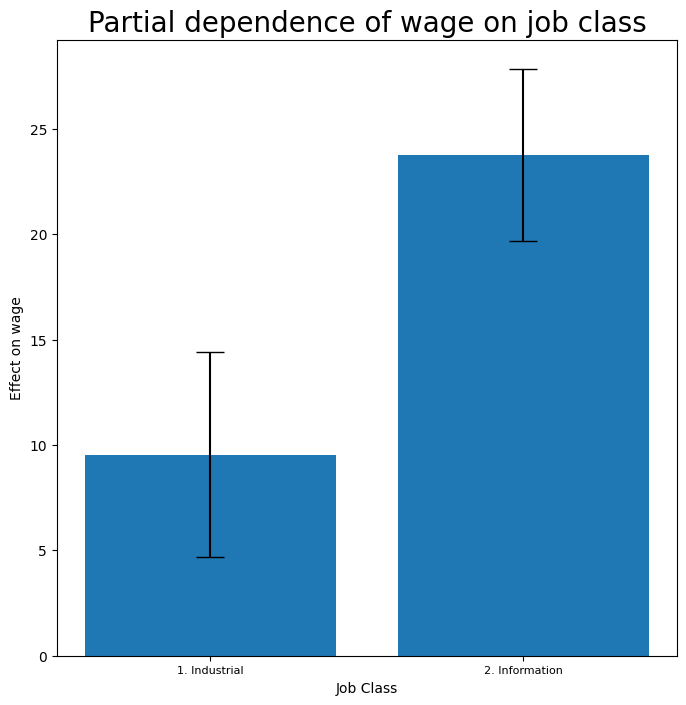

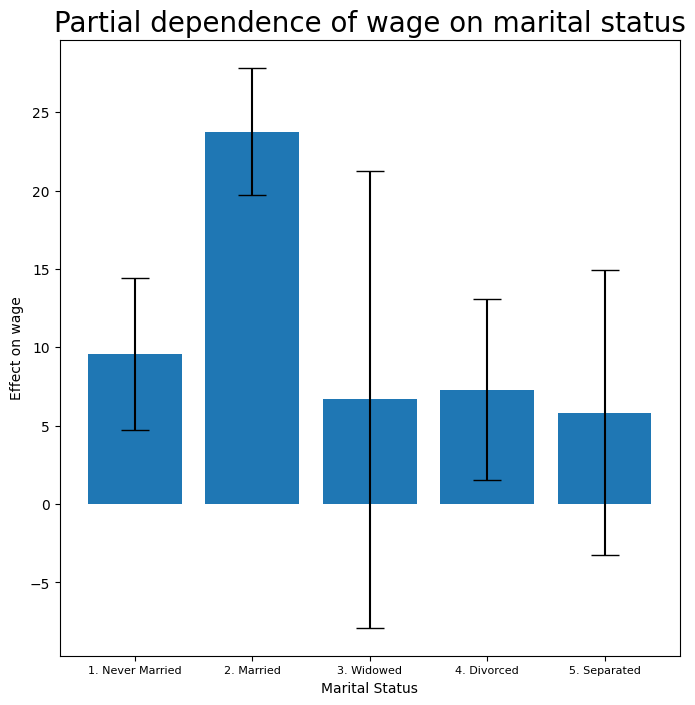

In [19]:
fig, ax = subplots(figsize=(8,8))
plot_gam(gam_full, 0)
ax.set_xlabel('Age')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of age on wage', fontsize=20);

fig, ax = subplots(figsize=(8, 8))
ax = plot_gam(gam_full, 1)
ax.set_xlabel('Job Class')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of wage on job class',
             fontsize=20);
ax.set_xticklabels(Wage['jobclass'].cat.categories, fontsize=8);

fig, ax = subplots(figsize=(8, 8))
plot_gam(gam_full, 2)
ax.set_xlabel('Marital Status')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of wage on marital status', fontsize=20)
ax.set_xticks(range(len(Wage['maritl'].cat.categories)))  # Set x-ticks positions
ax.set_xticklabels(Wage['maritl'].cat.categories, fontsize=8);  # Set x-tick labels

### Results
1. Mid age (highest wage)
2. Information > Industrial Jobs
3. Married (corresponds with highest wage)

# Question 8

In [20]:
Auto = load_data('Auto')
y = Auto['mpg']

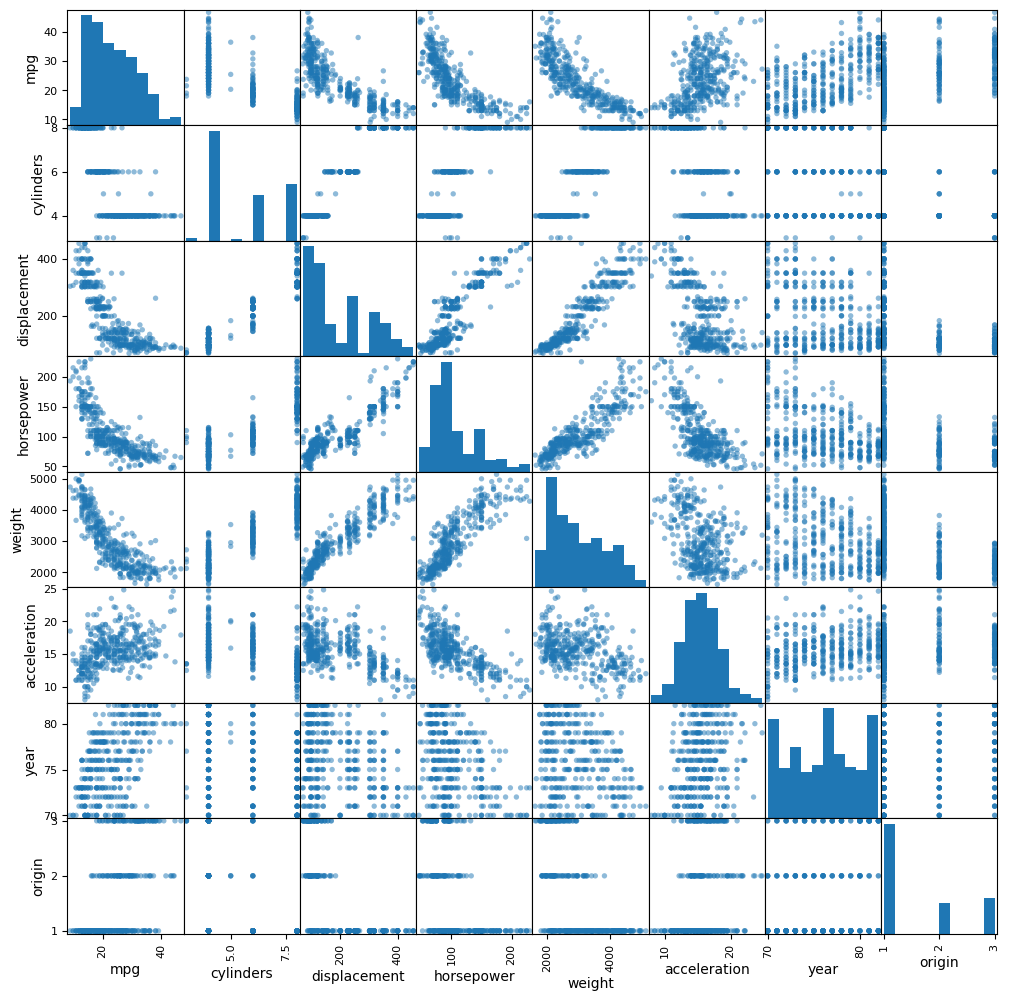

In [21]:
pd.plotting.scatter_matrix(Auto, figsize=(12,12), marker = 'o', 
                           hist_kwds = {'bins': 10}, s = 15, alpha = 0.5);

### Polynomial Regression

In [22]:
horsepower = Auto['horsepower']

In [23]:
def plot_mpg_fit(hist_df, 
                  basis,
                  title):

    X = basis.transform(Auto)
    Xnew = basis.transform(hist_df)
    M = sm.OLS(y, X).fit()
    preds = M.get_prediction(Xnew)
    bands = preds.conf_int(alpha=0.05)
    fig, ax = subplots(figsize=(8,8))
    ax.scatter(horsepower,
               y,
               facecolor='gray',
               alpha=0.5)
    for val, ls in zip([preds.predicted_mean,
                      bands[:,0],
                      bands[:,1]],
                     ['b','r--','r--']):
        ax.plot(hist_df.values, val, ls, linewidth=3)
    ax.set_title(title, fontsize=20)
    ax.set_xlabel('Horsepower', fontsize=20)
    ax.set_ylabel('mpg', fontsize=20);
    return ax

In [24]:
horse_grid = np.linspace(horsepower.min(),
                       horsepower.max(),
                       100)
horse_df = pd.DataFrame({'horsepower': horse_grid})

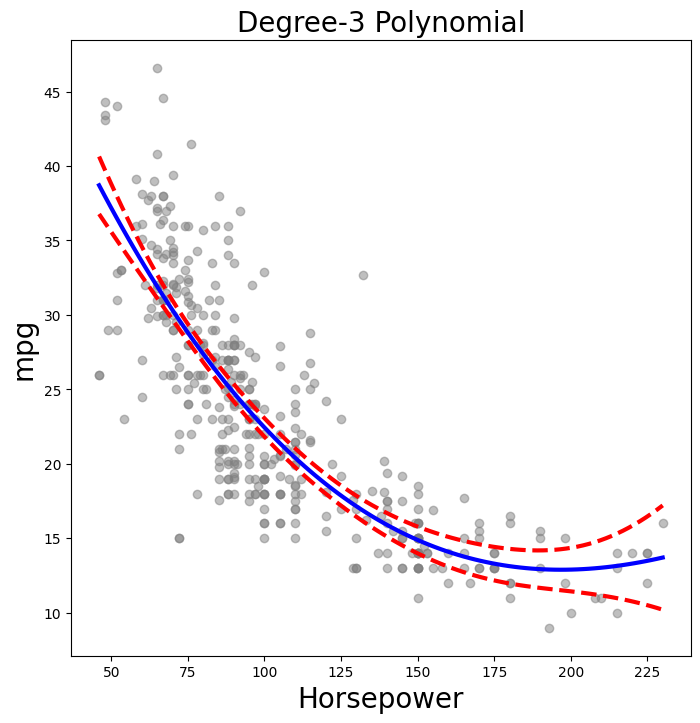

In [25]:
poly_horse = MS([poly('horsepower', degree=3)]).fit(Auto)

plot_mpg_fit(horse_df, 
               poly_horse,
               'Degree-3 Polynomial');

In [26]:
degrees = range(1, 5)
models = [MS([poly('horsepower', degree=d)]) 
          for d in degrees]
Xs = [model.fit_transform(Auto) for model in models]
anova_lm(*[sm.OLS(y, X_).fit()
           for X_ in Xs])

df_resid          ssr  df_diff      ss_diff           F        Pr(>F)
0     390.0  9385.915872      0.0          NaN         NaN           NaN
1     389.0  7442.029412      1.0  1943.886460  101.666567  2.145699e-21
2     388.0  7426.436007      1.0    15.593405    0.815546  3.670461e-01
3     387.0  7399.522632      1.0    26.913375    1.407588  2.361851e-01

This verifies out assumption of non-linearity.

### Step Function

In [27]:
cuts = range(1, 20)
cv_error = np.zeros(len(cuts))

# loop through models and get cv errors
for i, cut in enumerate(cuts):
    cut_horse = pd.qcut(horsepower, cut + 1)
    X = pd.get_dummies(cut_horse)
    CV = cross_validate(sklearn_sm(sm.OLS), 
                        X, 
                        y,
                        cv=cv)
    cv_error[i] = np.mean(CV['test_score'])
cv_error

array([29.82444399, 23.41049429, 20.26054905, 20.94466903, 18.9431238 ,
       19.74372876, 18.83251652, 18.69517885, 19.38914021, 18.70211447,
       17.9802214 , 19.46457473, 19.12644741, 19.03149541, 18.25730498,
       19.42660673, 19.07914753, 19.26482791, 18.92616421])

In [28]:
min_idx = np.argmin(cv_error)
min_idx

10

In [29]:
# the model with best cuts
# Final model
cuts = min_idx
cut_age, bins = pd.qcut(horsepower, cuts + 1, retbins=True)
X = pd.get_dummies(cut_age)
mod = sm.OLS(y, X).fit()

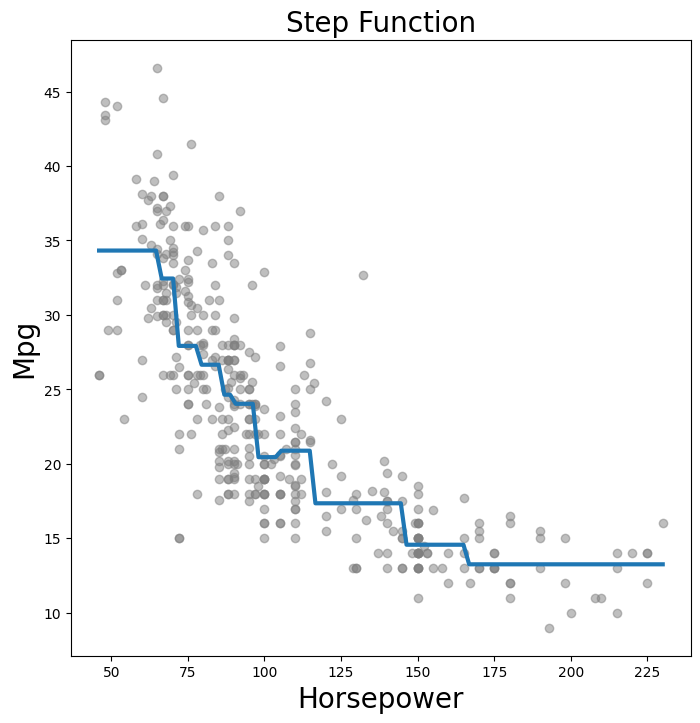

In [30]:
cut_hp_grid = pd.cut(horse_grid, bins=bins, include_lowest=True)
Xnew = pd.get_dummies(cut_hp_grid)
preds = mod.get_prediction(Xnew)
bands = preds.conf_int(alpha=0.05)
fig, ax = subplots(figsize=(8,8))
ax.scatter(horsepower,
           y,
           facecolor='grey',
           alpha=0.5) # just age against wage
ax.plot(horse_df.values, preds.predicted_mean, linewidth=3)
ax.set_title('Step Function', fontsize=20)
ax.set_xlabel('Horsepower', fontsize=20)
ax.set_ylabel('Mpg', fontsize=20);

### Natural Spline

In [31]:
ns_horse = MS([ns('horsepower', df=5)]).fit(Auto)
M_ns = sm.OLS(y, ns_horse.transform(Auto)).fit()
summarize(M_ns)

coef  std err       t  P>|t|
intercept                34.8412    1.442  24.165    0.0
ns(horsepower, df=5)[0] -10.7387    1.468  -7.314    0.0
ns(horsepower, df=5)[1] -14.3807    1.794  -8.015    0.0
ns(horsepower, df=5)[2] -21.6880    1.437 -15.094    0.0
ns(horsepower, df=5)[3] -23.0278    3.299  -6.979    0.0
ns(horsepower, df=5)[4] -21.3810    1.626 -13.149    0.0

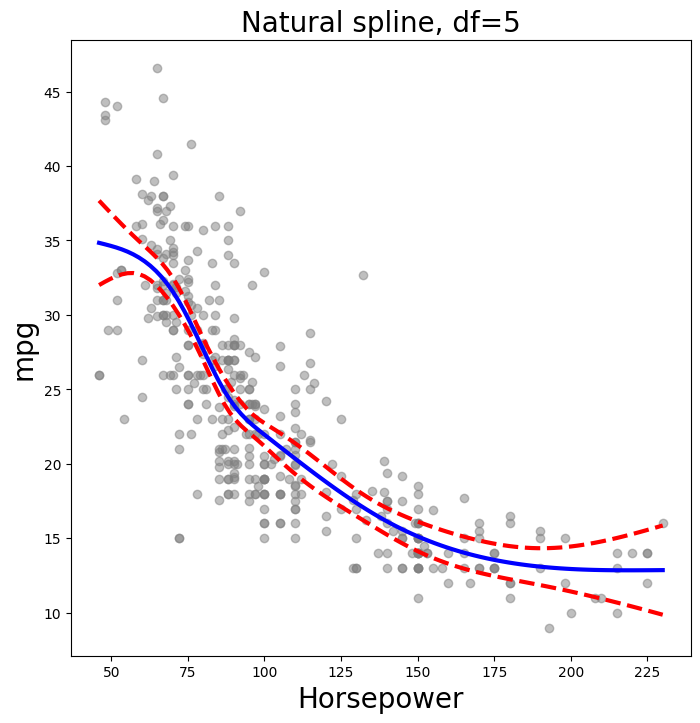

In [32]:
plot_mpg_fit(horse_df,
              ns_horse,
              'Natural spline, df=5');

# Question 9

In [33]:
Boston = load_data('Boston')
nox = Boston['nox']
dis = Boston['dis']

### (a) cubic poly

In [34]:
model = MS([poly('dis', degree=3)]).fit(Boston)
X = model.transform(Boston)
result = sm.OLS(nox, X).fit();

In [35]:
summarize(result)

coef  std err        t  P>|t|
intercept               0.5547    0.003  201.021    0.0
poly(dis, degree=3)[0] -2.0031    0.062  -32.271    0.0
poly(dis, degree=3)[1]  0.8563    0.062   13.796    0.0
poly(dis, degree=3)[2] -0.3180    0.062   -5.124    0.0

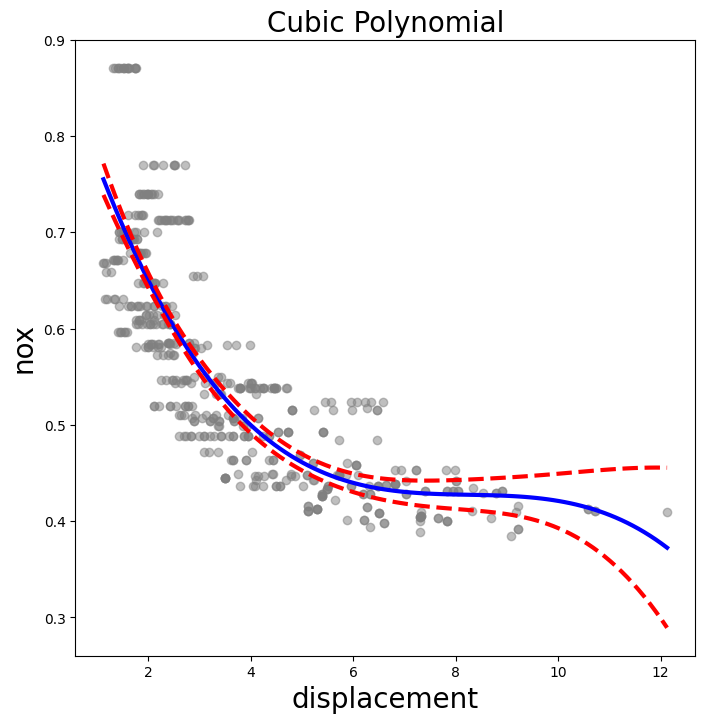

In [36]:
dis_grid = np.linspace(dis.min(),
                       dis.max(),
                       100)
dis_df = pd.DataFrame({'dis': dis_grid})

Xnew = model.transform(dis_df)
preds = result.get_prediction(Xnew)
bands = preds.conf_int(alpha=0.05)
fig, ax = subplots(figsize=(8,8))
ax.scatter(dis,
           nox,
           facecolor='gray',
           alpha=0.5)
for val, ls in zip([preds.predicted_mean,
                    bands[:,0],
                    bands[:,1]],
                   ['b','r--','r--']):
    ax.plot(dis_df.values, val, ls, linewidth=3)
ax.set_title('Cubic Polynomial', fontsize=20)
ax.set_xlabel('displacement', fontsize=20)
ax.set_ylabel('nox', fontsize=20);

### (b) Plots

In [37]:
def plot_nox_fit(degree):
    model = MS([poly('dis', degree=degree)]).fit(Boston)
    X = model.transform(Boston)
    result = sm.OLS(nox, X).fit();
    
    Xnew = model.transform(dis_df)
    preds = result.get_prediction(Xnew)
    bands = preds.conf_int(alpha=0.05)
    fig, ax = subplots(figsize=(8,8))
    ax.scatter(dis,
               nox,
               facecolor='gray',
               alpha=0.5)
    for val, ls in zip([preds.predicted_mean,
                        bands[:,0],
                        bands[:,1]],
                       ['b','r--','r--']):
        ax.plot(dis_df.values, val, ls, linewidth=3)
    ax.set_title(f'Polynomial degree={degree}', fontsize=20)
    ax.set_xlabel('displacement', fontsize=20)
    ax.set_ylabel('nox', fontsize=20);

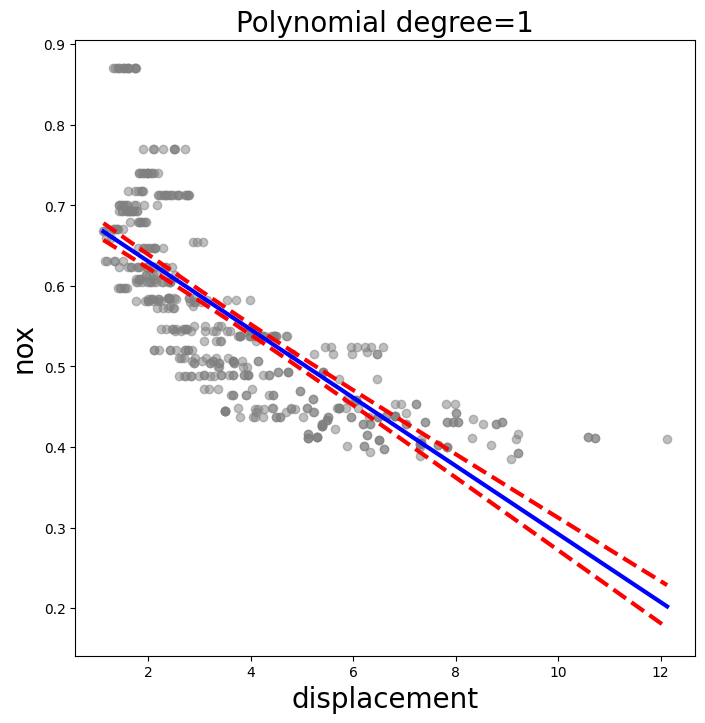

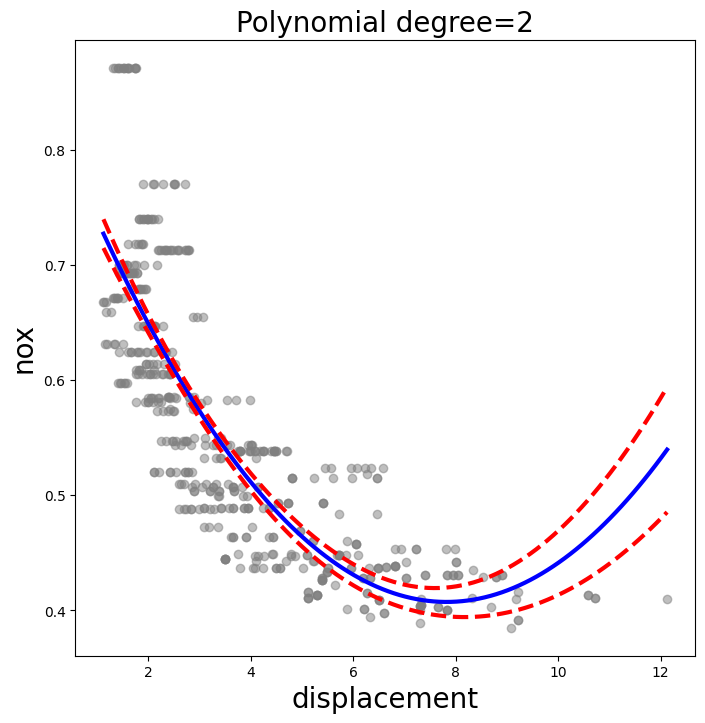

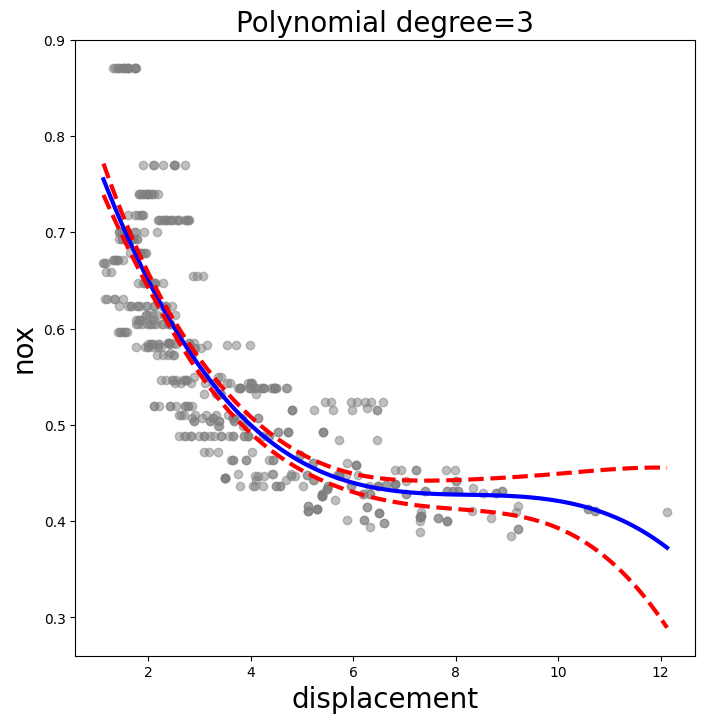

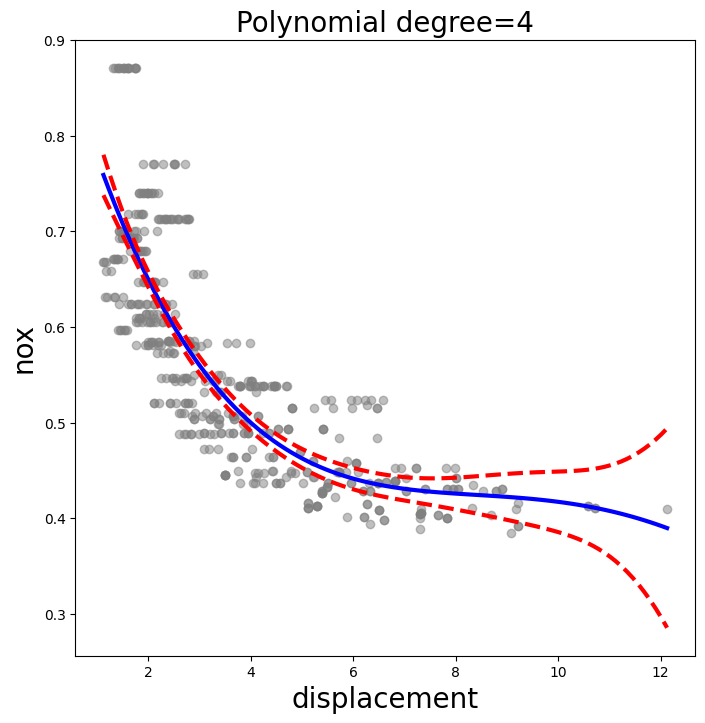

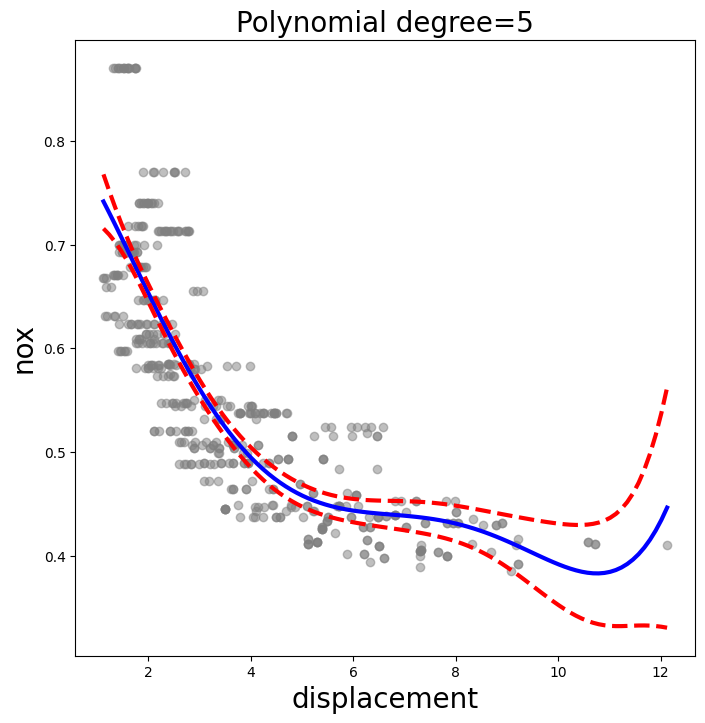

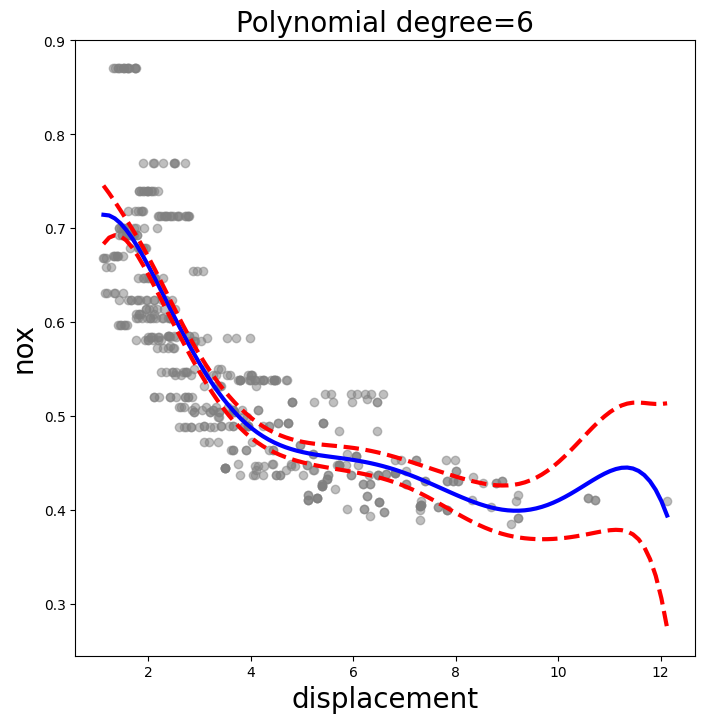

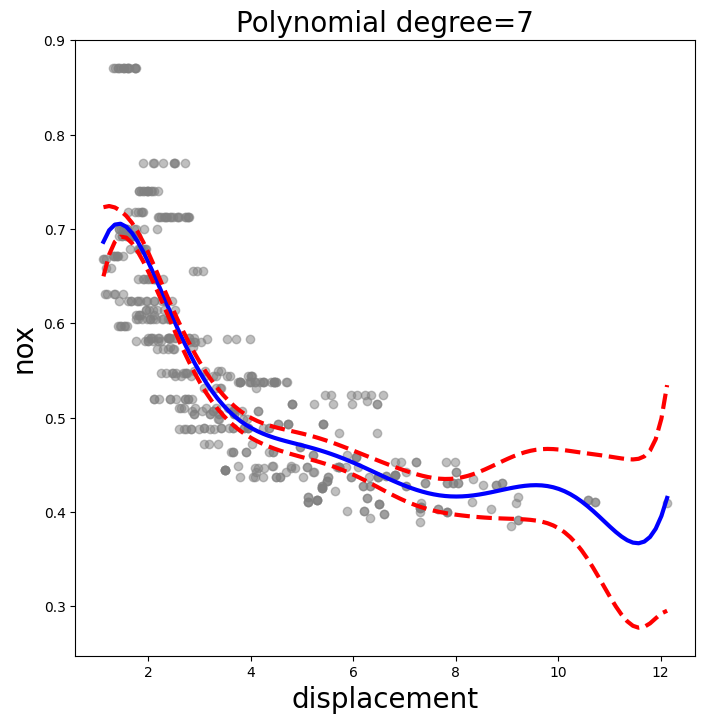

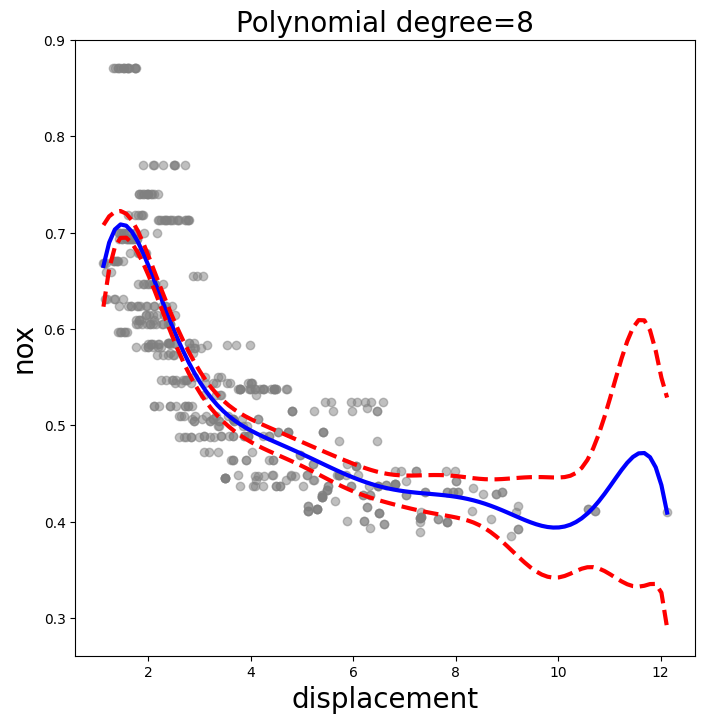

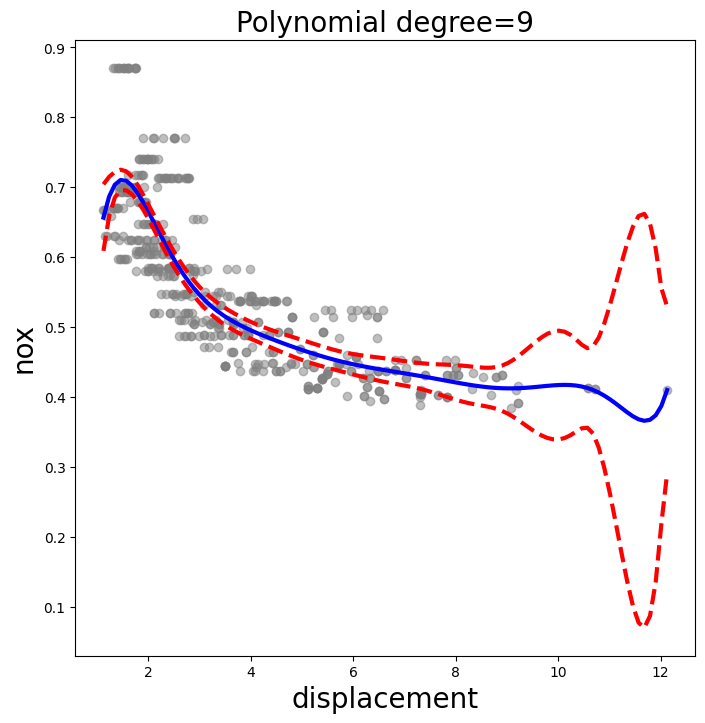

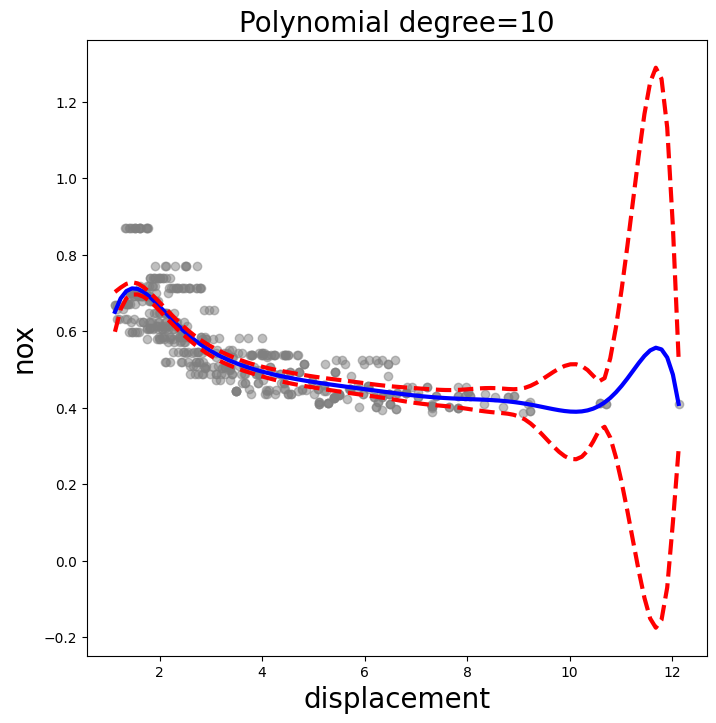

In [38]:
for degree in range(1, 11): 
    plot_nox_fit(degree)

### (c) Cross-validation

In [39]:
degrees = range(1, 12)
cv_error = np.zeros(len(degrees))

# loop through models and get cv errors
for i, degree in enumerate(degrees):
    X = np.power.outer(np.asarray(dis), np.arange(degree+1))
    CV = cross_validate(sklearn_sm(sm.OLS), 
                        X, 
                        nox,
                        cv=cv)
    cv_error[i] = np.mean(CV['test_score'])
cv_error

array([0.00550455, 0.00404589, 0.00384482, 0.00385288, 0.00405327,
       0.00490166, 0.00711742, 0.0065405 , 0.02188365, 0.00468504,
       0.05257903])

In [40]:
np.argmin(cv_error)

2

Therefore the best polynomial degree is 3.

### (d) Regression Spline

In [41]:
bs_dis = MS([bs('dis',
                 df=4)]).fit(Boston) # could use degree=0 for stepwise plot
Xbs = bs_dis.transform(Boston)
summarize(sm.OLS(nox, Xbs).fit())

coef  std err       t  P>|t|
intercept         0.7345    0.015  50.306  0.000
bs(dis, df=4)[0] -0.0581    0.022  -2.658  0.008
bs(dis, df=4)[1] -0.4636    0.024 -19.596  0.000
bs(dis, df=4)[2] -0.1998    0.043  -4.634  0.000
bs(dis, df=4)[3] -0.3888    0.046  -8.544  0.000

In [42]:
dis_grid = np.linspace(dis.min(),
                           dis.max(),
                           100)
dis_df = pd.DataFrame({'dis': dis_grid})

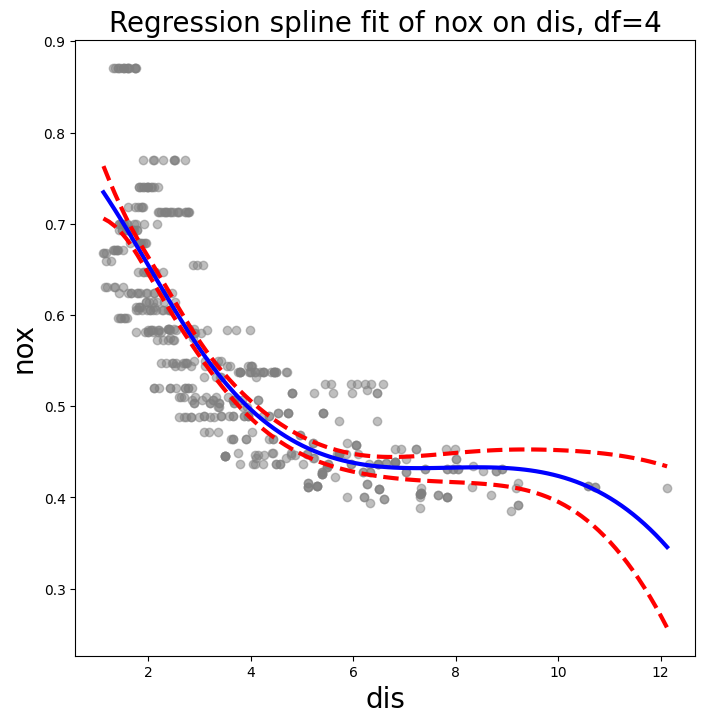

In [43]:
Xnew = bs_dis.transform(dis_df)
M = sm.OLS(nox, Xbs).fit()
preds = M.get_prediction(Xnew)
bands = preds.conf_int(alpha=0.05)

fig, ax = subplots(figsize=(8,8))
ax.scatter(dis,
           nox,
           facecolor='gray',
           alpha=0.5)

for val, ls in zip([preds.predicted_mean,
                    bands[:,0],
                    bands[:,1]],
                   ['b','r--','r--']):
        ax.plot(dis_df.values, val, ls, linewidth=3)

ax.set_title('Regression spline fit of nox on dis, df=4', fontsize=20)
ax.set_xlabel('dis', fontsize=20)
ax.set_ylabel('nox', fontsize=20);

### (e) Regression Spline Plots

In [44]:
def plot_nox_fit_bs(df, dis_grid):
    bs_dis = MS([bs('dis',
                 df=df)]).fit(Boston)
    Xbs = bs_dis.transform(Boston)
    
    M = sm.OLS(nox, Xbs).fit()
    
    yhat = M.predict(Xbs)
    rss = np.sum((nox - yhat)**2)

    dis_df = pd.DataFrame({'dis': dis_grid})
    Xnew = bs_dis.transform(dis_df)
    
    preds = M.get_prediction(Xnew)
    bands = preds.conf_int(alpha=0.05)

    
    fig, ax = subplots(figsize=(8,8))
    ax.scatter(dis,
               nox,
               facecolor='gray',
               alpha=0.5)
    
    for val, ls in zip([preds.predicted_mean,
                        bands[:,0],
                        bands[:,1]],
                       ['b','r--','r--']):
            ax.plot(dis_df.values, val, ls, linewidth=3)
    
    ax.set_title(f'Regression spline fit of nox on dis, df={df}', fontsize=20)
    ax.set_xlabel('dis', fontsize=20)
    ax.set_ylabel('nox', fontsize=20);
    return rss

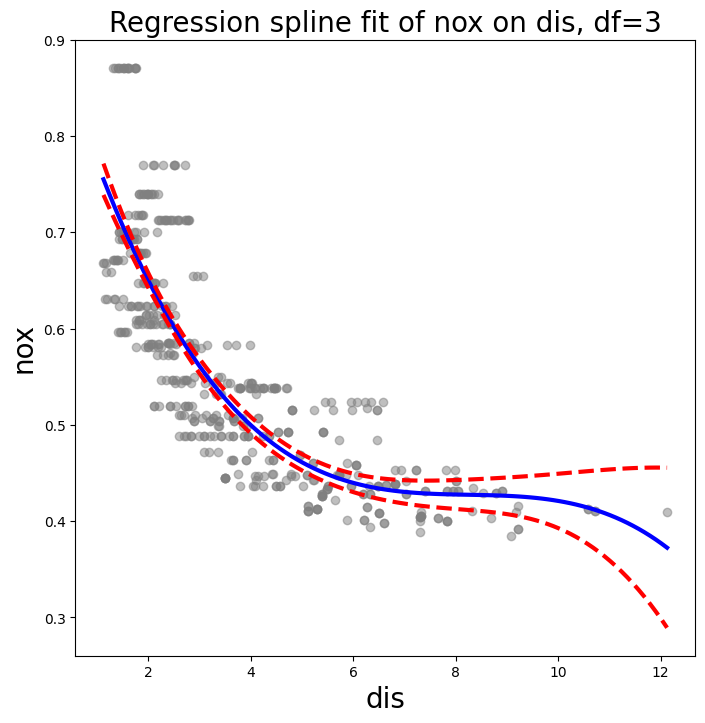

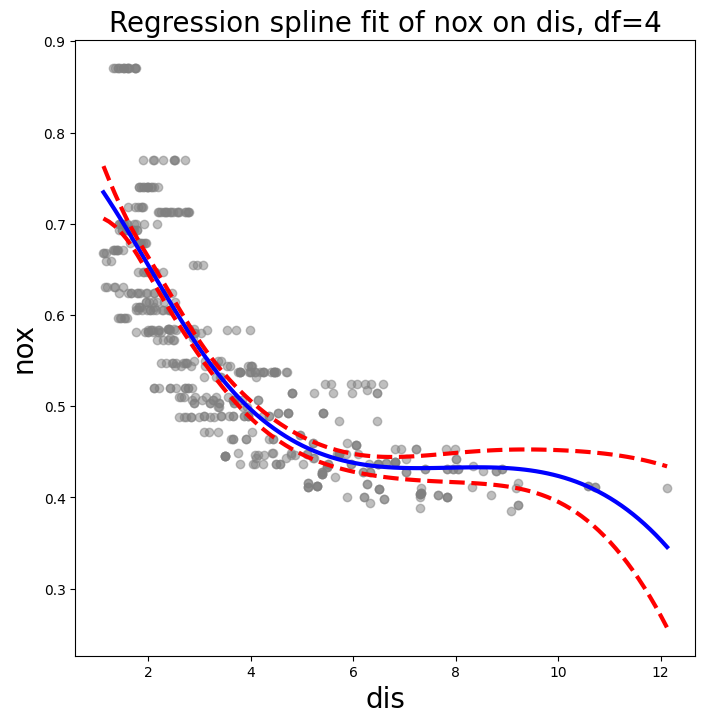

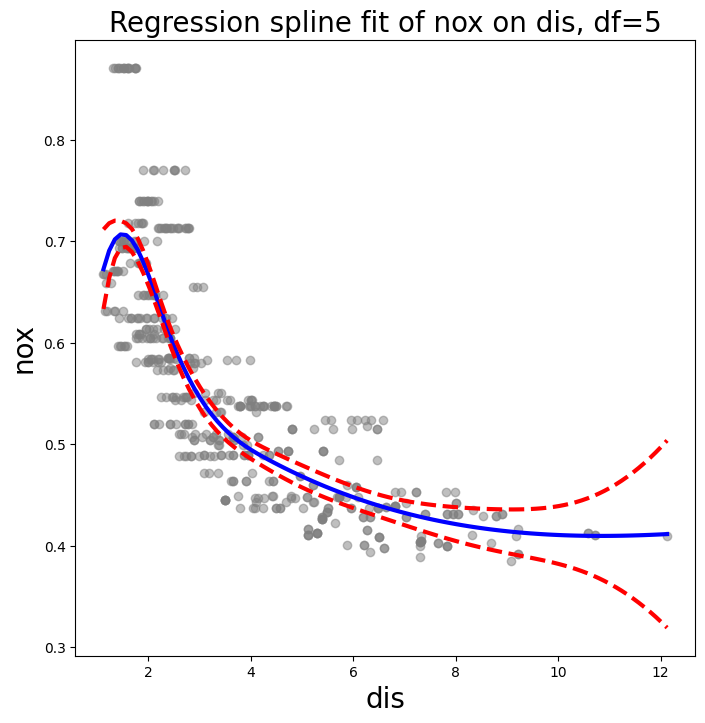

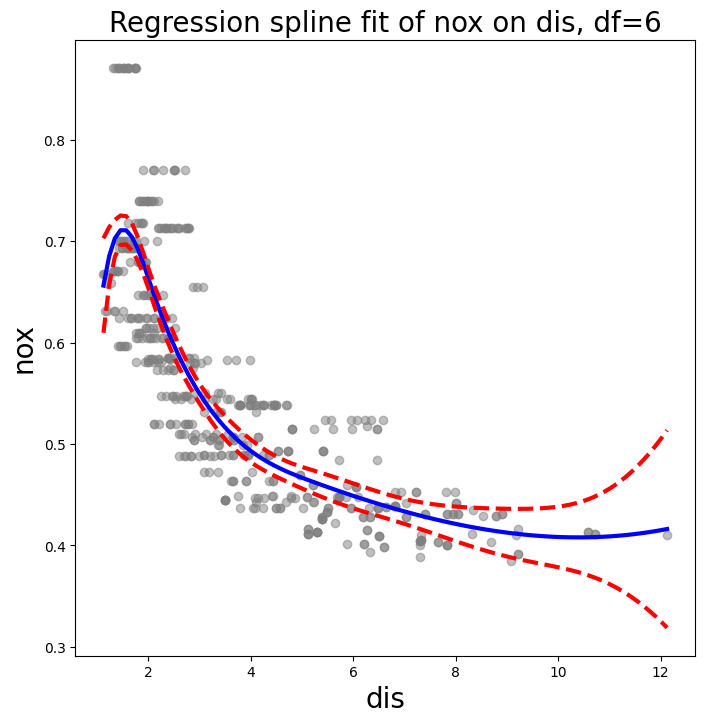

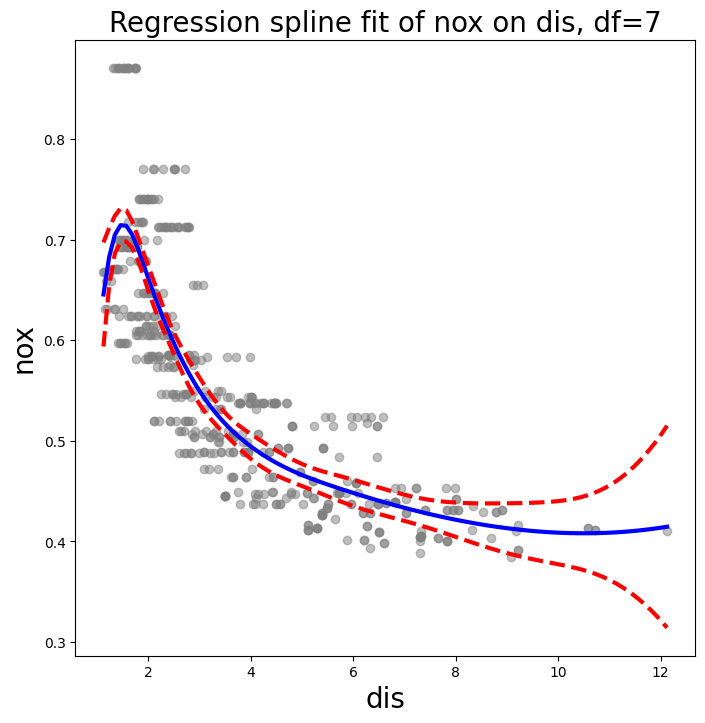

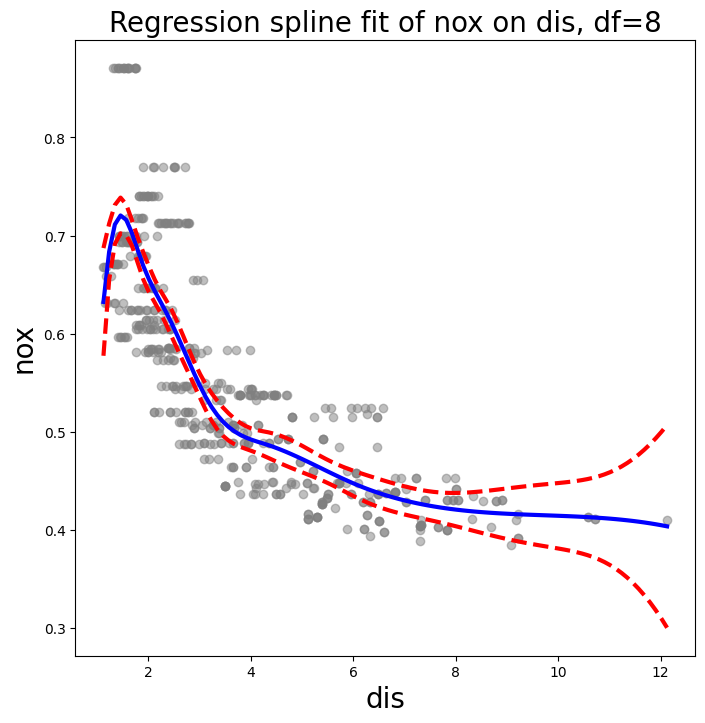

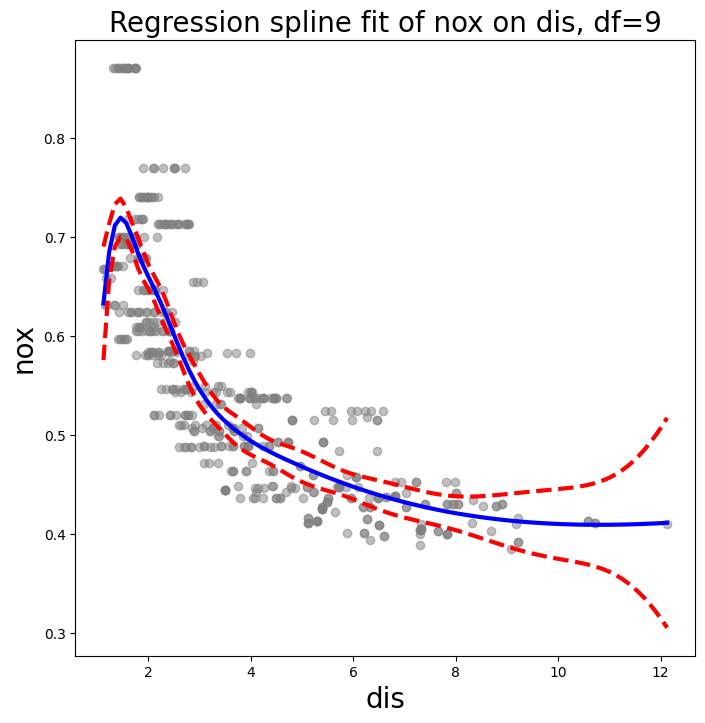

In [45]:
rss = []
for df in range(3, 10):
    rss.append(plot_nox_fit_bs(df, dis_grid))

In [46]:
rss

[1.9341067071790705,
 1.9227749928119253,
 1.8401728014885235,
 1.8339659031602094,
 1.829884445923284,
 1.8169950567252338,
 1.825652510387056]

### (f) Cross-validation on Regression Spline

In [47]:
dfs = range(3, 11)
cv_error = np.zeros(len(dfs))

# loop through models and get cv errors
for i, df in enumerate(dfs):
    bs_dis = MS([bs('dis',
                 df=df)]).fit(Boston)
    
    Xbs = bs_dis.transform(Boston)
    
    CV = cross_validate(sklearn_sm(sm.OLS), 
                        Xbs, 
                        nox,
                        cv=cv)

    cv_error[i] = np.mean(CV['test_score'])
cv_error

array([0.00384482, 0.00384329, 0.00370746, 0.00369342, 0.0036883 ,
       0.00369055, 0.00374206, 0.00369561])

In [48]:
dfs[np.argmin(cv_error)]

7

7 degrees of freedom performed the best.

#### ANOVA Test

In [49]:
models = [MS([bs('dis', df=df)]) 
          for df in dfs]
Xs = [model.fit_transform(Boston) for model in models]
anova_lm(*[sm.OLS(nox, X_).fit()
           for X_ in Xs])

df_resid       ssr  df_diff   ss_diff          F    Pr(>F)
0     502.0  1.934107      0.0       NaN        NaN       NaN
1     501.0  1.922775      1.0  0.011332   3.129199  0.077510
2     500.0  1.840173      1.0  0.082602  22.810203  0.000002
3     499.0  1.833966      1.0  0.006207   1.714006  0.191069
4     498.0  1.829884      1.0  0.004081   1.127075  0.288915
5     497.0  1.816995      1.0  0.012889   3.559344  0.059794
6     496.0  1.825653      1.0 -0.008657  -2.390715  1.000000
7     495.0  1.792535      1.0  0.033118   9.145274  0.002623

Also unstable. But 7 is is still seems reasonable. Otherwise 5 degrees of freedom also seems to be promising.

# Question 10

In [50]:
College = load_data('College')

In [51]:
College.head()

Private  Apps  Accept  Enroll  Top10perc  Top25perc  F.Undergrad  \
0     Yes  1660    1232     721         23         52         2885   
1     Yes  2186    1924     512         16         29         2683   
2     Yes  1428    1097     336         22         50         1036   
3     Yes   417     349     137         60         89          510   
4     Yes   193     146      55         16         44          249   

   P.Undergrad  Outstate  Room.Board  Books  Personal  PhD  Terminal  \
0          537      7440        3300    450      2200   70        78   
1         1227     12280        6450    750      1500   29        30   
2           99     11250        3750    400      1165   53        66   
3           63     12960        5450    450       875   92        97   
4          869      7560        4120    800      1500   76        72   

   S.F.Ratio  perc.alumni  Expend  Grad.Rate  
0       18.1           12    7041         60  
1       12.2           16   10527         56  
2       12.9           30    8735         54  
3        7.7           37   19016         59  
4       11.9            2   10922         15

### (a) Split data, forward stepwise

In [52]:
# Clean objects}
College['Private'] = College['Private'].apply(lambda x: 1 if x == 'Yes' else 0)

In [53]:
y = College['Outstate']

(X_train, 
X_test, 
y_train, 
y_test) = train_test_split(College.drop(['Outstate'], axis=1), 
                           y,
                           test_size=0.25,
                           random_state=42)

In [54]:
def nCp(sigma2, estimator, X, Y):
    "Negative Cp statistic"
    n, p = X.shape
    Yhat = estimator.predict(X)
    RSS = np.sum((Y - Yhat)**2)
    return -(RSS + 2 * p * sigma2) / n 

In [55]:
# we need to estimate sigma^2, fit the biggest model, and estimate sigma^2 based on its MSE
design = MS(College.columns.drop('Outstate')).fit(College)
X_train_d = design.transform(X_train)
sigma2 = sm.OLS(y_train, X_train).fit().scale

In [56]:
neg_Cp = partial(nCp, sigma2)

In [57]:
strategy = Stepwise.first_peak(design,
                               direction='forward',
                               max_terms=len(design.terms))

In [58]:
college_Cp = sklearn_selected(sm.OLS,
                              strategy,
                              scoring=neg_Cp)
college_Cp.fit(X_train, y_train)
college_Cp.selected_state_

('Accept',
 'Apps',
 'Enroll',
 'Expend',
 'Grad.Rate',
 'PhD',
 'Private',
 'Room.Board',
 'Terminal',
 'Top25perc',
 'perc.alumni')

In [59]:
features = list(college_Cp.selected_state_)
design = MS(features).fit(College)
X_new_train = design.transform(X_train[features].copy())

# fit new model
mod1 = sm.OLS(y_train, X_new_train).fit()

### (b) GAM model

In [60]:
X_new_train.drop(['intercept'], axis=1).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 582 entries, 596 to 102
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   Accept       582 non-null    int64
 1   Apps         582 non-null    int64
 2   Enroll       582 non-null    int64
 3   Expend       582 non-null    int64
 4   Grad.Rate    582 non-null    int64
 5   PhD          582 non-null    int64
 6   Private      582 non-null    int64
 7   Room.Board   582 non-null    int64
 8   Terminal     582 non-null    int64
 9   Top25perc    582 non-null    int64
 10  perc.alumni  582 non-null    int64
dtypes: int64(11)
memory usage: 54.6 KB


In [61]:
X_train_arr = np.asarray(X_new_train.drop(['intercept'], axis=1))

In [62]:
formula = s_gam(0) + s_gam(1) + s_gam(2) + s_gam(3) + s_gam(4) + s_gam(5) + f_gam(6) + s_gam(7) + s_gam(8) + s_gam(9) + s_gam(10)

In [63]:
gam = LinearGAM(formula)
gam.fit(X_train_arr, y_train)

LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, 
   terms=s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + f(6) + s(7) + s(8) + s(9) + s(10) + intercept,
   tol=0.0001, verbose=False)

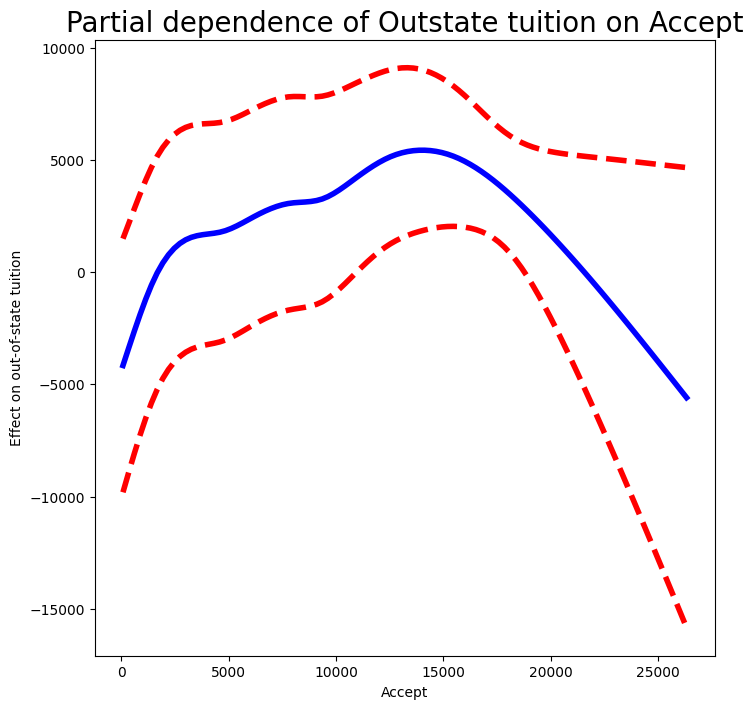

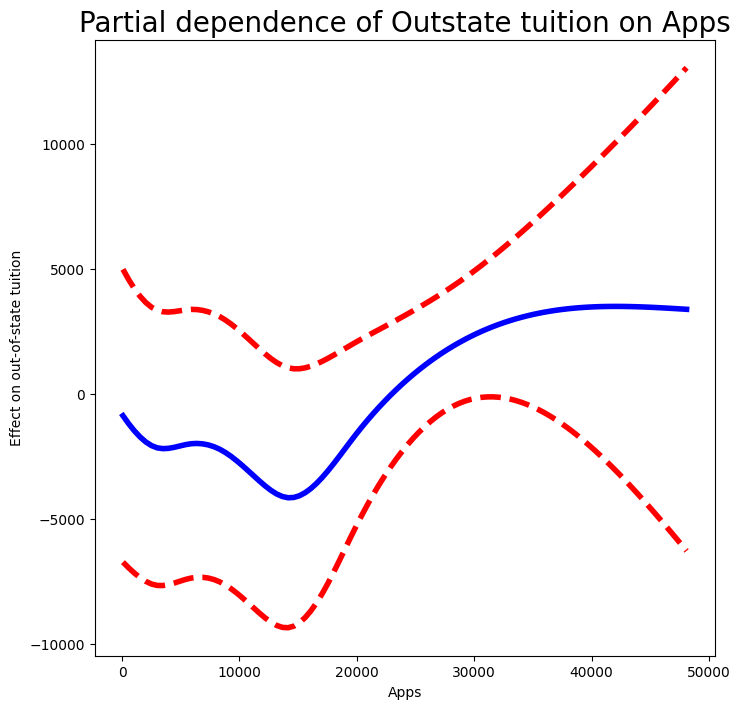

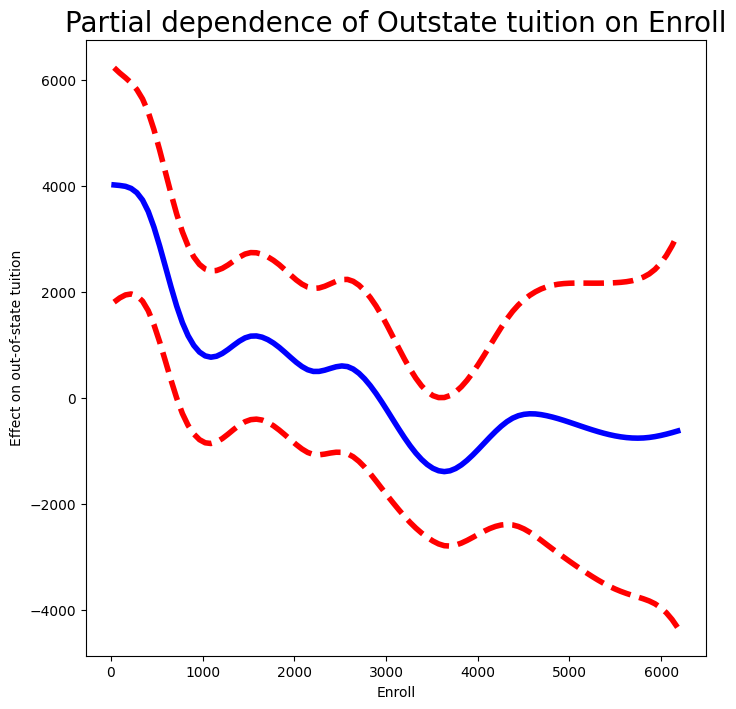

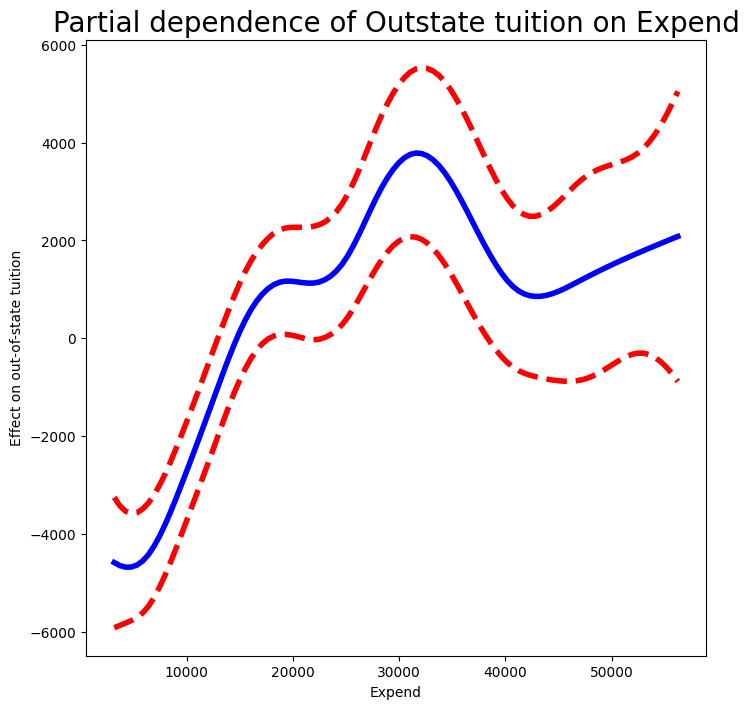

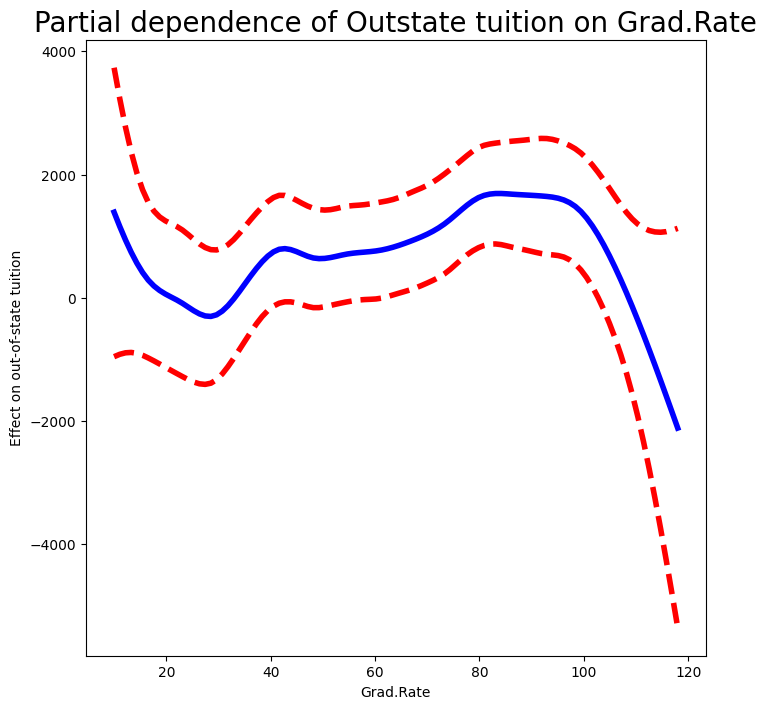

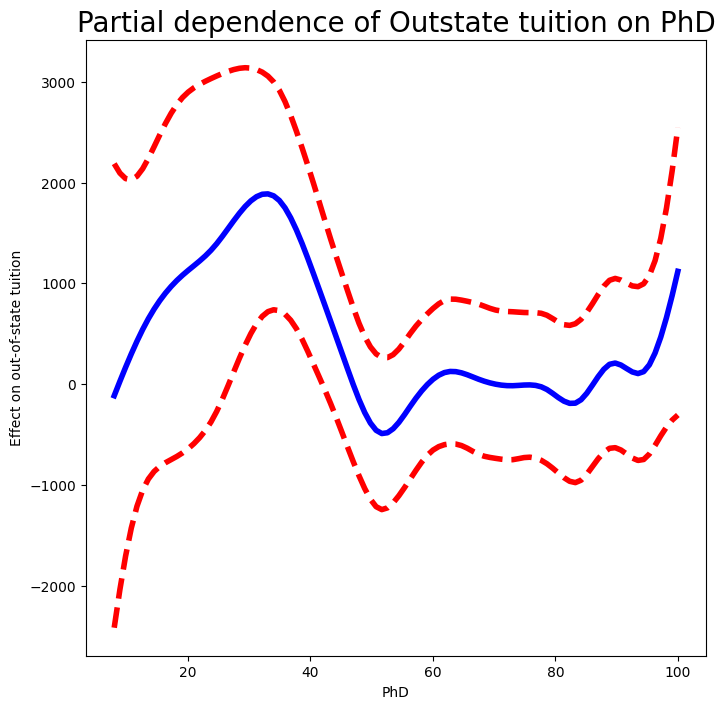

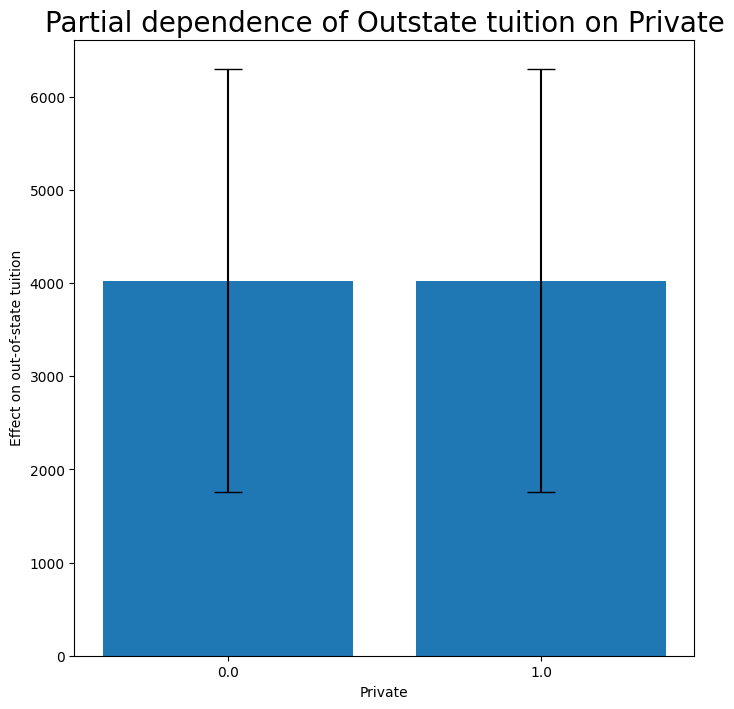

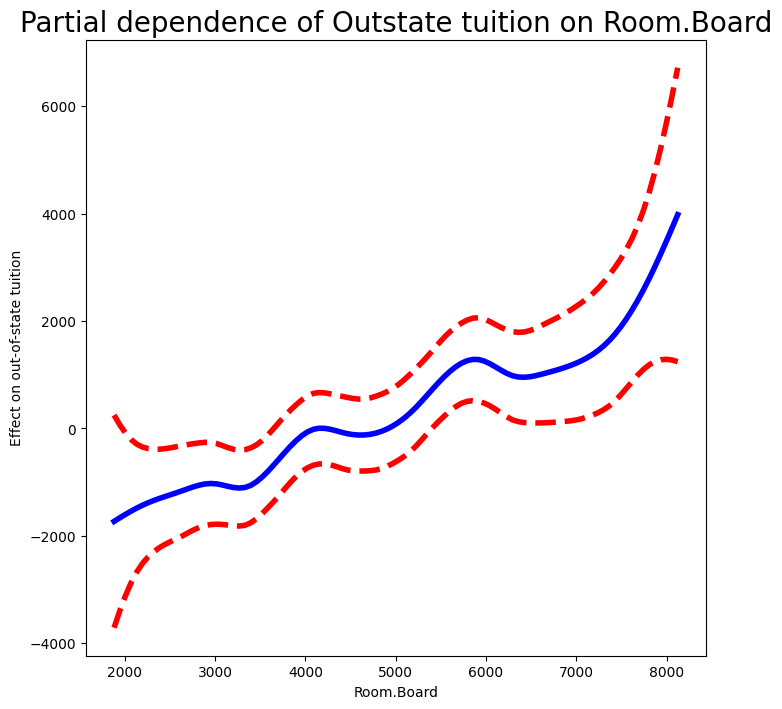

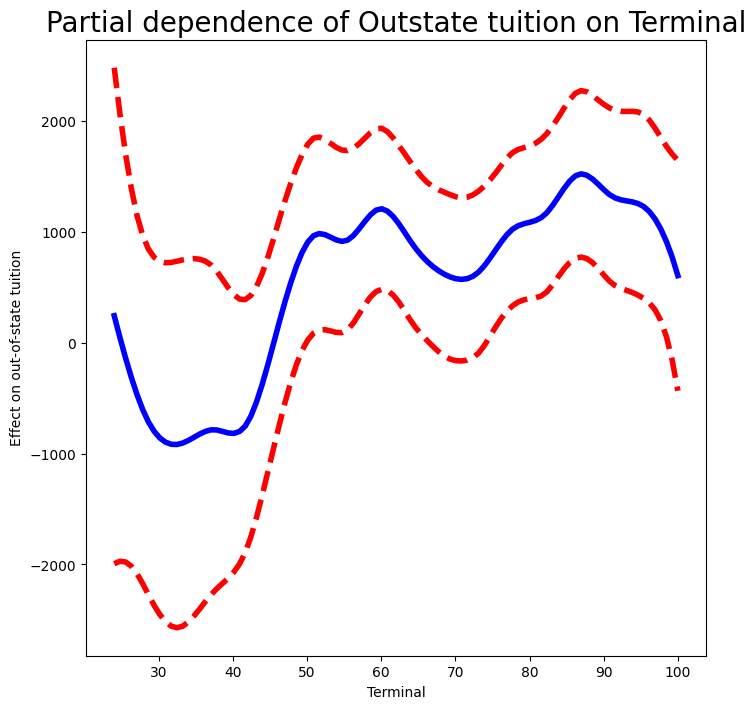

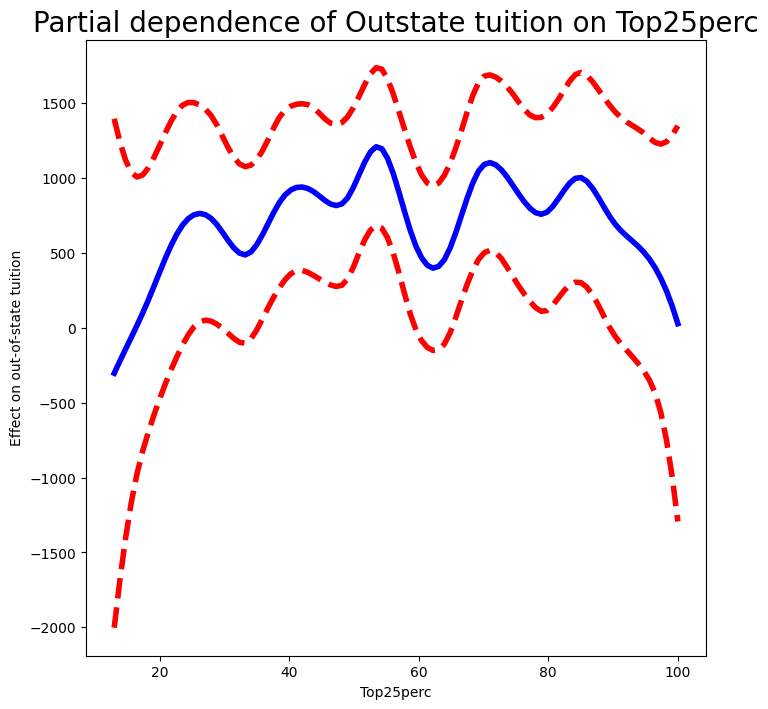

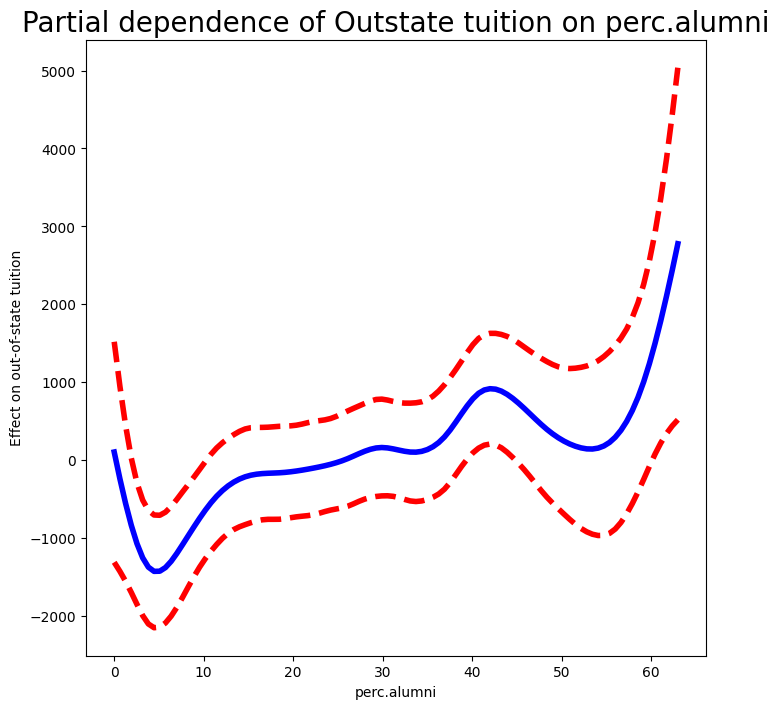

In [64]:
for i, col in enumerate(X_new_train.drop(['intercept'], axis = 1).columns):
    fig, ax = subplots(figsize=(8,8))
    plot_gam(gam, i, ax=ax)
    ax.set_xlabel(col)
    ax.set_ylabel('Effect on out-of-state tuition')
    ax.set_title(f'Partial dependence of Outstate tuition on {col}', fontsize=20);

In [65]:
# Most wrigly were Top25Per and Terminal
formula = s_gam(0) + s_gam(1) + s_gam(2) + s_gam(3) + s_gam(4) + s_gam(5) + f_gam(6) + s_gam(7) + s_gam(10)
gam2 = LinearGAM(formula)
gam2 = gam2.fit(X_train_arr, y_train)
anova_gam(gam2,gam)

deviance          df  deviance_diff    df_diff         F    pvalue
0  1.511095e+09  508.175665            NaN        NaN       NaN       NaN
1  1.416458e+09  486.355773   9.463711e+07  21.819892  1.489222  0.096872

We now remove Top25Per since its impact on the model is not statistically significant.

### (c) Testing

In [66]:
X_test_arr = np.asarray(X_test[features])
Yhat = gam2.predict(X_test_arr)
np.mean((y_test - Yhat)**2)

3437807.7661769055

In [67]:
r2_score(y_test, Yhat)

0.8078535862989626

Good fit, $R^2$ is just above $80$%.

### (d) Non-linear Variables

In [68]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     95.6442
Link Function:                     IdentityLink Log Likelihood:                                 -9197.5923
Number of Samples:                          582 AIC:                                             18588.473
                                                AICc:                                           18627.4392
                                                GCV:                                          4105635.2992
                                                Scale:                                        2912389.6486
                                                Pseudo R-Squared:                                   0.8438
Feature Function                  Lam

/var/folders/6z/lh7_g3fj0nqffqtv57pqq__80000gn/T/ipykernel_61197/3358381670.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


Cannot use the p-values since they are unstable.

# Question 11

### (a) Initialize Y

In [69]:
np.random.seed(42)

n = 100
X1 = np.random.normal(size=n)
X2 = np.random.normal(size=n)
epsilon = np.random.normal(size=n)

Y = 2*X1 - X2 + epsilon 

### (b) simple_reg function

In [70]:
def simple_reg(outcome, feature):
    df = pd.DataFrame({'Y':outcome, 
                       'X': feature})
    design = MS(['X'])
    X = design.fit_transform(df)
    mod = sm.OLS(outcome, X).fit()
    return mod.params[0], mod.params[1]

### (c) beta1

In [71]:
beta1 = 0.5

### (d) beta1 fixed
$Y - \beta_1 \cdot X_1 = \beta_0 + \beta_2 \cdot X_2 + \epsilon$

In [72]:
beta0, beta2 = simple_reg(Y - beta1*X1, X2)

### e) beta2 fixed
$Y - \beta_2 \cdot X_2 = \beta_0 + \beta_1 \cdot X_1 + \epsilon$

In [73]:
beta0, beta1 = simple_reg(Y - beta2*X2, X1)

### f) For loop 1000 times

In [74]:
# initial values
betas0 = [beta0]
betas1 = [beta1]
betas2 = [beta2]
for i in range(1000):
    # Update beta2 first based on the current values of beta1 and beta0
    beta2_update = simple_reg(Y - betas1[i]*X1, X2)[1]
    betas2.append(beta2_update)

    # Then, update beta0 and beta1 based on the new value of beta2
    beta0_update, beta1_update = simple_reg(Y - betas2[i+1]*X2, X1)
    betas0.append(beta0_update)
    betas1.append(beta1_update)

    print(f'Iteration: {i}')
    print(f'beta0 = {betas0[-1]}')
    print(f'beta1 = {betas1[-1]}')
    print(f'beta2 = {betas2[-1]}')

Iteration: 0
beta0 = 0.08867967376049063
beta1 = 2.2254914987366057
beta2 = -1.016450150520585
Iteration: 1
beta0 = 0.08864925157475351
beta1 = 2.2260782375308104
beta2 = -1.0123544474290729
Iteration: 2
beta0 = 0.08864868538684714
beta1 = 2.2260891573382287
beta2 = -1.012278222217032
Iteration: 3
beta0 = 0.08864867484951267
beta1 = 2.2260893605669825
beta2 = -1.012276803588088
Iteration: 4
beta0 = 0.08864867465340218
beta1 = 2.226089364349277
beta2 = -1.0122767771859564
Iteration: 5
beta0 = 0.08864867464975232
beta1 = 2.2260893644196695
beta2 = -1.012276776694586
Iteration: 6
beta0 = 0.08864867464968448
beta1 = 2.2260893644209796
beta2 = -1.0122767766854408
Iteration: 7
beta0 = 0.08864867464968317
beta1 = 2.2260893644210036
beta2 = -1.0122767766852707
Iteration: 8
beta0 = 0.08864867464968315
beta1 = 2.2260893644210045
beta2 = -1.0122767766852676
Iteration: 9
beta0 = 0.08864867464968315
beta1 = 2.2260893644210045
beta2 = -1.0122767766852674
Iteration: 10
beta0 = 0.08864867464968315
bet

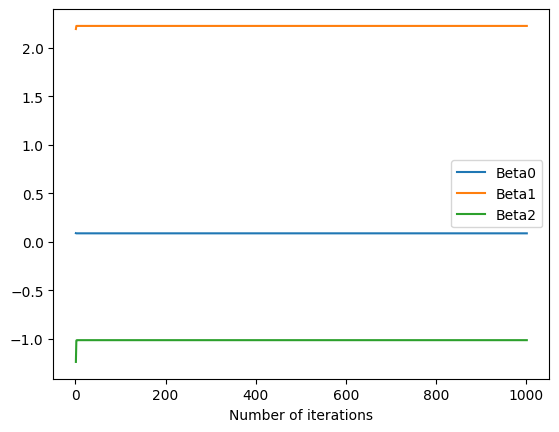

In [75]:
plt.plot(np.arange(1,1002),betas0,label = 'Beta0')
plt.plot(np.arange(1,1002),betas1,label = 'Beta1')
plt.plot(np.arange(1,1002),betas2,label = 'Beta2')
plt.legend()
plt.xlabel('Number of iterations');

In [76]:
# initial estimates
betas0[0], betas1[0], betas2[0]

(0.09031430667048836, 2.1939650807839657, -1.2365188569845675)

In [77]:
betas0[-1], betas1[-1], betas2[-1]

(0.08864867464968315, 2.2260893644210045, -1.0122767766852674)

### (g) Axline comparison

In [78]:
df = pd.DataFrame({'Y': Y, 
                   'X1': X1,
                   'X2': X2})
design = MS(['X1', 'X2'])
X = design.fit_transform(df)
mod = sm.OLS(Y, X).fit()

In [79]:
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.827
Method:                 Least Squares   F-statistic:                     237.7
Date:                Wed, 24 Jan 2024   Prob (F-statistic):           4.07e-38
Time:                        19:37:37   Log-Likelihood:                -147.62
No. Observations:                 100   AIC:                             301.2
Df Residuals:                      97   BIC:                             309.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0886      0.108      0.819      0.415      -0.126       0.303
X1             2.2261      0.120     18.533      0.000       1.988       2.464
X2            -1.0123      0.114     -8.850      0.000      -1.239      -0.785
==============================================================================
Omnibus:                        3.125   Durbin-Watson:                   2.220
Prob(Omnibus):                  0.210   Jarque-Bera (JB):                3.080
Skew:                           0.108   Prob(JB):                        0.214
Kurtosis:                       3.832   Cond. No.                         1.23
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Same coefficients, as expected.

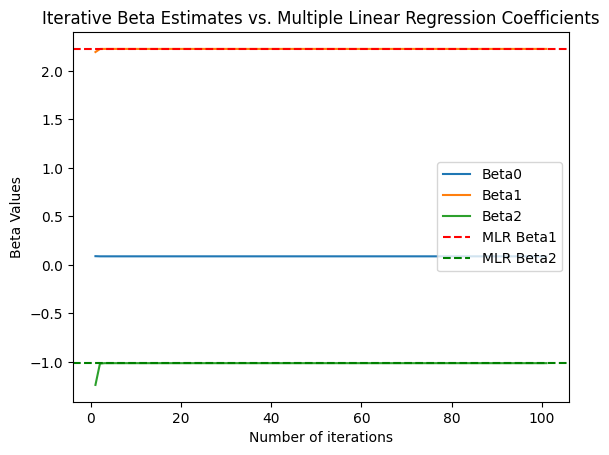

In [80]:
mlr_coefs = mod.params

# Plotting the iterative beta values (using 100 for visualisation purposes)
plt.plot(np.arange(1, 102), betas0[:101], label='Beta0')
plt.plot(np.arange(1, 102), betas1[:101], label='Beta1')
plt.plot(np.arange(1, 102), betas2[:101], label='Beta2')

# Overlaying the MLR coefficient estimates
plt.axhline(y=mlr_coefs[1], color='r', linestyle='--', label='MLR Beta1')
plt.axhline(y=mlr_coefs[2], color='g', linestyle='--', label='MLR Beta2')

plt.legend()
plt.xlabel('Number of iterations')
plt.ylabel('Beta Values')
plt.title('Iterative Beta Estimates vs. Multiple Linear Regression Coefficients')

plt.show()

### (g) Backfitting Iterations

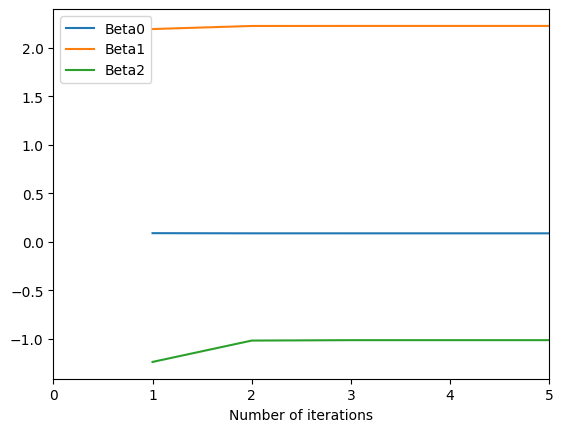

In [81]:
plt.plot(np.arange(1,1002),betas0,label = 'Beta0')
plt.plot(np.arange(1,1002),betas1,label = 'Beta1')
plt.plot(np.arange(1,1002),betas2,label = 'Beta2')
plt.legend()
plt.xlabel('Number of iterations');
plt.xlim(0,5);

#### Result: 2 Iterations

# Question 12

In [82]:
np.random.seed(42)

n = 100
p = 100
Xs = np.asarray([np.random.normal(size=n) for _ in range(p)]).T
epsilon = np.random.normal(size=n)
betas = np.random.uniform(low=-5, high=5, size=p).T

Y = 2.4 + Xs @ betas + 2*epsilon 

In [83]:
zeros_column = np.zeros((100, 1))
Xs_extra = np.concatenate((zeros_column, Xs), axis=1)

In [84]:
est_betas = np.zeros(101) # initial beta estimates (size p + 1)
# initial estimates
for i in range(0, p):
    est_betas[i+1] = 0
    est_betas[0], est_betas[i+1] = simple_reg(Y - Xs_extra @ est_betas, Xs_extra[:, i+1])

In [85]:
MSE = []
num_iterations = 100
num_betas = est_betas.shape[0] # 101
betas_mat = np.zeros((num_iterations+1, num_betas)) # beta0, beta1, beta2, etc. (as cols)
betas_mat[0, :] = est_betas # initial values
threshold = 1e-6


for i in range(num_iterations):
    est_betas = betas_mat[i, :] # update estimates for next iteration
    
    for j in range(0, p):
        est_betas[j+1] = 0
        est_betas[0], est_betas[j+1] = simple_reg(Y - Xs_extra @ est_betas, Xs_extra[:, j+1])

    mse = np.mean((betas - est_betas[1:])**2) # do not include coef estimate
    MSE.append(mse)
    
    betas_mat[i+1, :] = est_betas # new estimates


    print(f'Iteration: {i}')
    print(f'MSE: {MSE[i]}')
    print('Intercept Estimate:', betas_mat[i+1, 0])
    print('Current Estimates:', betas_mat[i+1, 1:])

    if i > 0:  # Check change in MSE starting from the second iteration
        delta_mse = abs(MSE[i] - MSE[i-1])
        if delta_mse < threshold:
            print(f"Converged at iteration {i}")
            num_iterations = i + 1
            break  # Exit the loop if convergence criterion is met

Iteration: 0
MSE: 2.2697889849949573
Intercept Estimate: 5.5133914943145825
Current Estimates: [ 0.42768941  1.92291284 -5.03079792  0.54576484 -0.8784927  -2.8444943
 -2.62803742 -1.9643515  -0.65114555  1.66427471 -3.2027078   3.5064073
  2.13822896  1.03578103  1.95223553  0.90880234  1.21877345 -4.57951652
  1.28659362 -7.95499865  0.88300495  2.87311035 -1.96732378  1.9557292
 -2.01805638  2.36687219 -2.38922538  1.7910801  -2.27626197 -4.42624899
 -3.71503626 -4.15429509  1.53034269  2.09202821 -0.29498107  0.88311026
  0.18159776 -1.42308345 -3.55383346  1.2753697   6.27729175 -2.96245287
  3.27977941 -2.82980131  1.00808842 -4.43715481 -1.361397   -3.81587851
  0.2153839  -0.79979914 -1.06089654  0.63898406  2.70450006 -2.08441196
 -2.70286911 -3.48391412  3.16700973  0.21810209  1.30615575 -1.26243781
 -1.27541695 -0.84397086  2.61588625  2.85305085 -2.1490442   0.91691946
 -2.50751402  0.03105062  3.05095765  1.68283451 -1.10021114 -1.30337217
  1.23799767  0.32220806  0.0402

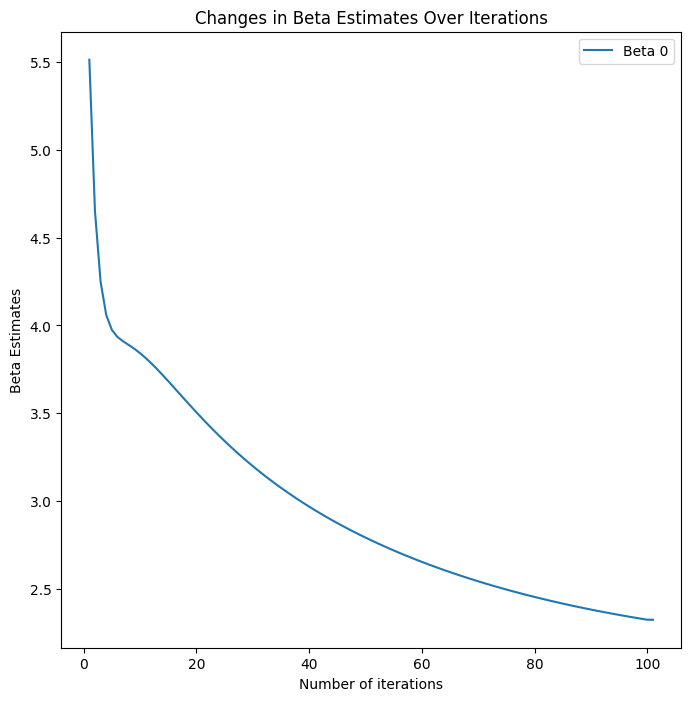

In [86]:
#for i in range(p + 1):  # Loop over each beta, including the intercept
#    plt.plot(np.arange(1, num_iterations + 2), betas_mat[:, i], label=f'Beta {i}')

plt.figure(figsize=(8, 8))
beta_i = 0
plt.plot(np.arange(1, num_iterations + 2), betas_mat[:num_iterations+1, beta_i], label=f'Beta {beta_i}')
plt.xlabel('Number of iterations')
plt.ylabel('Beta Estimates')
plt.title('Changes in Beta Estimates Over Iterations')
plt.legend()
plt.show()

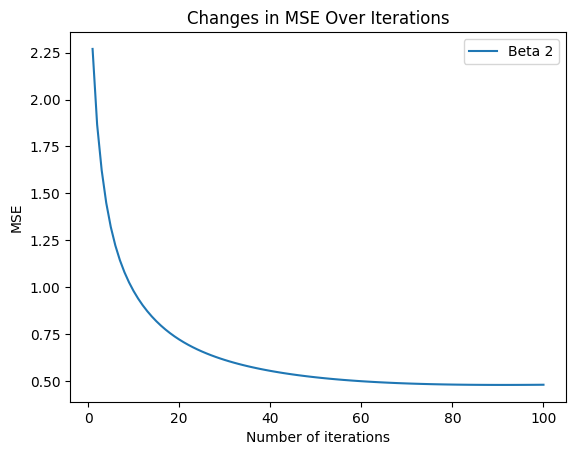

In [87]:
# plt.figure(figsize=(8, 8))
plt.plot(np.arange(1, num_iterations + 1), MSE, label=f'Beta {2}')
plt.xlabel('Number of iterations')
plt.ylabel('MSE')
plt.title('Changes in MSE Over Iterations')
plt.legend()
plt.show()

### Results:
Coefficients start to converge at around iteration 100.